In [1]:
# Step 1: Import necessary libraries
import pandas as pd
import numpy as np


In [2]:
# Step 2: Load the dataset
df = pd.read_csv("bangalore house price.csv")
print(df.shape)
# Step 3: Define features and target
X = df.drop(columns=['price'])  # All columns except the target
y = df['price']

(7120, 108)




*   A target column "price"

*   107 independent variables (e.g., bath, total_sqft_int, location dummy variables)




In [3]:

# Step 4: Split into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [4]:
# Step 5: Standardize and apply Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
# pipeline makes sure that standardization is done only on the training data and then applied to test data.
# It simplifies your workflow: you can later call lr_pipeline.predict(X_test)
# and it will automatically scale X_test using the same StandardScaler

lr_pipeline = make_pipeline(StandardScaler(), LinearRegression())
lr_pipeline.fit(X_train, y_train)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

We create a pipeline to standardize features and apply Linear Regression.

*   StandardScaler() makes all features have mean 0 and variance 1.
*   Linear regression is then trained on scaled data.



In [5]:
# Evaluate Linear Regression
y_train_pred = lr_pipeline.predict(X_train)
y_test_pred = lr_pipeline.predict(X_test)

from sklearn.metrics import r2_score
print("Linear Regression:")
print("Train Accuracy R²:", r2_score(y_train, y_train_pred))
print("Test Accuracy R² :", r2_score(y_test, y_test_pred))

Linear Regression:
Train Accuracy R²: 0.8439925248308795
Test Accuracy R² : 0.919680813221159


In [6]:
# Step 6: Apply ShuffleSplit Cross-Validation
from sklearn.model_selection import ShuffleSplit, cross_val_score

shuffle_split = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
cv_scores = cross_val_score(lr_pipeline, X, y, cv=shuffle_split, scoring='r2')
#print("Cross-Validation R² Scores:", cv_scores)
print("Average CV R²:", np.round(cv_scores.mean(),2))


Average CV R²: 0.86


We apply ShuffleSplit, a kind of cross-validation that:

Randomly shuffles the data

*   Performs 5 different train-test splits
*   Reports R² scores on each split
*   This helps verify the model's consistency and generalization.


In [10]:
# Step 7: Apply LassoCV to find optimal alpha
from sklearn.linear_model import Lasso, LassoCV
# Use Lasso: model = Lasso(alpha=0.5) when you already know the best alpha value (via tuning or prior knowledge)
# Use LassoCV: It does automatic cross-validation to find the best alpha
# It searches over a list of alpha values and selects the one that gives the best performance
# eg. model = LassoCV(alphas=[0.1, 0.5, 1.0], cv=5)
# In real projects, it’s common to use LassoCV to find the best alpha, then use Lasso(alpha=best_alpha) to train your final model

lasso_cv_pipeline = make_pipeline(StandardScaler(), LassoCV(cv=5, max_iter=10000,alphas = None)) #CV=5 means K=5 folds
lasso_cv_pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lassocv', LassoCV(cv=5, max_iter=10000))])

1. scikit-learn automatically sets alphas=None, which then triggers this logic inside LassoCV:

  “If alphas is None, use 100 values on a log scale between alpha_max and alpha_max * eps, where eps=0.001

2. max_iter=100, it defaults to 100 iterations (in scikit-learn). But if the loss hasn’t converged in 100 steps, you’ll get warning, hence better to keep highest number

3. Runs 5-fold CV on transformed data to find the best alpha. Fits the final Lasso model using that alpha.

In [11]:
print("All alphas tried by LassoCV:", lasso_cv_pipeline.named_steps['lassocv'].alphas_)


All alphas tried by LassoCV: [93.80009819 87.47828551 81.58254184 76.08415157 70.9563344  66.17411494
 61.71420107 57.55487047 53.67586483 50.05829119 46.6845299  43.53814883
 40.60382332 37.86726152 35.31513483 32.93501294 30.7153033  28.64519466
 26.71460441 24.91412948 23.23500054 21.66903927 20.20861855 18.84662529
 17.57642582 16.39183355 15.28707883 14.25678088 13.29592157 12.39982095
 11.56411452 10.78473191 10.05787707  9.38000982  8.74782855  8.15825418
  7.60841516  7.09563344  6.61741149  6.17142011  5.75548705  5.36758648
  5.00582912  4.66845299  4.35381488  4.06038233  3.78672615  3.53151348
  3.29350129  3.07153033  2.86451947  2.67146044  2.49141295  2.32350005
  2.16690393  2.02086185  1.88466253  1.75764258  1.63918336  1.52870788
  1.42567809  1.32959216  1.2399821   1.15641145  1.07847319  1.00578771
  0.93800098  0.87478286  0.81582542  0.76084152  0.70956334  0.66174115
  0.61714201  0.5755487   0.53675865  0.50058291  0.4668453   0.43538149
  0.40603823  0.378672

In [12]:
# Extract best alpha
# To access the actual LassoCV model after training, you can use named_steps['lassocv'] attribute on your model.
# To Check the best alpha: model.alpha_
# To access coefficients: model.coef_ etc.

best_alpha = lasso_cv_pipeline.named_steps['lassocv'].alpha_
print("Best alpha from LassoCV (using .alpha_):", best_alpha)

Best alpha from LassoCV (using .alpha_): 0.17576425824625858


In [13]:
# Evaluate performance with best alpha
y_train_lasso = lasso_cv_pipeline.predict(X_train)
y_test_lasso = lasso_cv_pipeline.predict(X_test)
print("LassoCV Train Accuracy R²:", np.round(r2_score(y_train, y_train_lasso)*100,2))
print("LassoCV Test Accuracy R² :", np.round(r2_score(y_test, y_test_lasso)*100,2))

LassoCV Train Accuracy R²: 84.37
LassoCV Test Accuracy R² : 91.89


In [14]:
# Step 8: Plot alpha vs CV error
mse_path = lasso_cv_pipeline.named_steps['lassocv'].mse_path_.mean(axis=1)
# mse_path: It contains the mean squared error (MSE) for each alpha, for each fold during cross-validation.
alphas_tested = lasso_cv_pipeline.named_steps['lassocv'].alphas_
alphas_tested

array([93.80009819, 87.47828551, 81.58254184, 76.08415157, 70.9563344 ,
       66.17411494, 61.71420107, 57.55487047, 53.67586483, 50.05829119,
       46.6845299 , 43.53814883, 40.60382332, 37.86726152, 35.31513483,
       32.93501294, 30.7153033 , 28.64519466, 26.71460441, 24.91412948,
       23.23500054, 21.66903927, 20.20861855, 18.84662529, 17.57642582,
       16.39183355, 15.28707883, 14.25678088, 13.29592157, 12.39982095,
       11.56411452, 10.78473191, 10.05787707,  9.38000982,  8.74782855,
        8.15825418,  7.60841516,  7.09563344,  6.61741149,  6.17142011,
        5.75548705,  5.36758648,  5.00582912,  4.66845299,  4.35381488,
        4.06038233,  3.78672615,  3.53151348,  3.29350129,  3.07153033,
        2.86451947,  2.67146044,  2.49141295,  2.32350005,  2.16690393,
        2.02086185,  1.88466253,  1.75764258,  1.63918336,  1.52870788,
        1.42567809,  1.32959216,  1.2399821 ,  1.15641145,  1.07847319,
        1.00578771,  0.93800098,  0.87478286,  0.81582542,  0.76

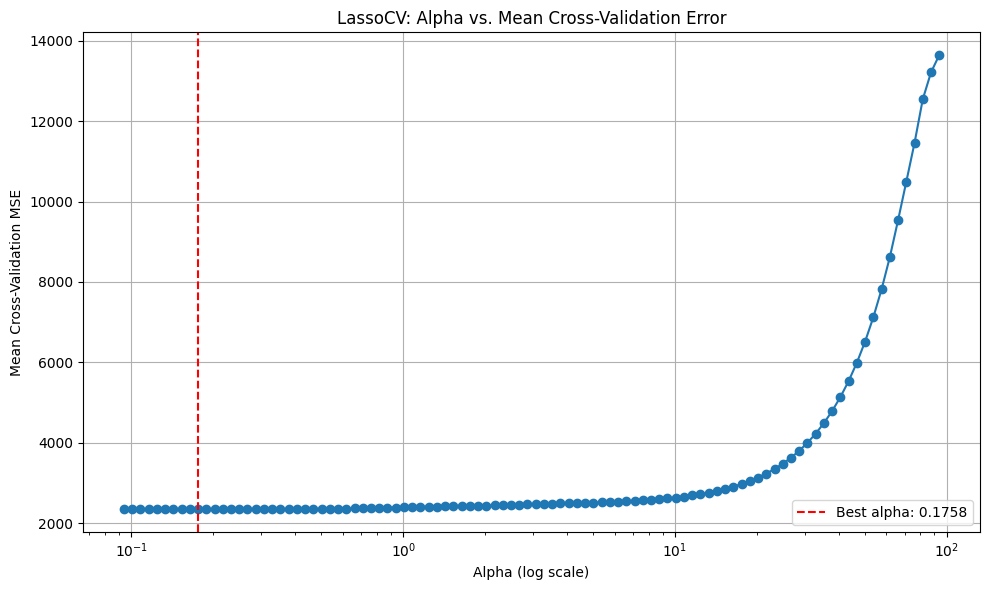

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(alphas_tested, mse_path, marker='o')
plt.axvline(best_alpha, color='red', linestyle='--', label=f'Best alpha: {best_alpha:.4f}')
plt.xscale('log')
plt.xlabel('Alpha (log scale)')
plt.ylabel('Mean Cross-Validation MSE')
plt.title('LassoCV: Alpha vs. Mean Cross-Validation Error')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



*   We plot the mean cross-validation error (MSE) against different alphas.

*   A red line shows the best alpha (0.1758 in this case).
* Helps visually confirm the best tradeoff between bias and variance.






In [21]:
# Step 9: Feature selection — count zeroed coefficients
lasso_model = lasso_cv_pipeline.named_steps['lassocv']
coef_df = pd.DataFrame({
    'Feature': X.columns, # putting all independent variables in 'Feature' column
    'Coefficient': lasso_model.coef_ # putting corresponding beta 1, beta 2,....,beta n coefficients in 'Coefficient' column
})
zeroed_features = coef_df[coef_df['Coefficient'] == 0]
print("Number of features removed by LassoCV:", len(zeroed_features))


Number of features removed by LassoCV: 14


In [20]:
coef_df

,Feature,Coefficient
0,bath,0.238021
1,balcony,-0.010586
2,total_sqft_int,80.627350
3,bhk,-10.516459
4,price_per_sqft,63.578564
...,...,...
102,location_Hosur Road,-0.178306
103,location_Horamavu Banaswadi,0.583545
104,location_Domlur,-0.926682
105,location_Mahadevpura,0.206374






*   We examine which coefficients were set to zero by Lasso.
*   These features are considered not useful
*   Lasso at α = 0.1758 removed 14 features (i.e., retained 93)




In [27]:
# Step 10: Test with higher alpha to simplify model
# Higher alpha ⇒ more regularization ⇒ more coefficients shrink to 0.
# This code Counts how many are non-zero → i.e., how many features are retained (not shrunk to zero).
for alpha_val in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]:
    lasso_custom = make_pipeline(StandardScaler(), Lasso(alpha=alpha_val, max_iter=10000))
    lasso_custom.fit(X_train, y_train)

    y_test_pred = lasso_custom.predict(X_test)
    r2_test = r2_score(y_test, y_test_pred)
    non_zero_count = sum(lasso_custom.named_steps['lasso'].coef_ != 0)

    print('\n',alpha_val)
    print('Test Rsquared:', np.round(r2_test,4))
    print('Retained Features:',non_zero_count)



 0.1
Test Rsquared: 0.9193
Retained Features: 102

 0.2
Test Rsquared: 0.9188
Retained Features: 90

 0.3
Test Rsquared: 0.9179
Retained Features: 81

 0.4
Test Rsquared: 0.9169
Retained Features: 75

 0.5
Test Rsquared: 0.9158
Retained Features: 70

 0.6
Test Rsquared: 0.9145
Retained Features: 62

 0.7
Test Rsquared: 0.9132
Retained Features: 54

 0.8
Test Rsquared: 0.912
Retained Features: 49

 0.9
Test Rsquared: 0.9107
Retained Features: 44

 1
Test Rsquared: 0.9096
Retained Features: 38


In [28]:
# Step 11: Final model with alpha = 0.9 (recommended) Here we are using Lasso
final_alpha = 0.9
final_lasso = make_pipeline(StandardScaler(), Lasso(alpha=final_alpha, max_iter=10000))
final_lasso.fit(X_train, y_train)

final_coef = final_lasso.named_steps['lasso'].coef_
selected_features = X.columns[final_coef != 0]
print("\nFinal Selected Features (alpha = 0.9):", len(selected_features))


Final Selected Features (alpha = 0.9): 44


In [29]:
# Final evaluation
y_train_final = final_lasso.predict(X_train)
y_test_final = final_lasso.predict(X_test)

print("Final Lasso Train R²:", np.round(r2_score(y_train, y_train_lasso)*100,2))
print("Final Lasso Test R² :", np.round(r2_score(y_test, y_test_lasso)*100,2))

Final Lasso Train R²: 84.37
Final Lasso Test R² : 91.89


In [30]:
# prompt: print the feature names which are finalized from above after using alpha as 0.9

selected_features

Index(['total_sqft_int', 'bhk', 'price_per_sqft',
       'area_typeSuper built-up  Area', 'area_typePlot  Area',
       'availability_Ready To Move', 'location_Whitefield',
       'location_Sarjapur  Road', 'location_Raja Rajeshwari Nagar',
       'location_Hennur Road', 'location_Uttarahalli', 'location_Thanisandra',
       'location_Electronic City Phase II', 'location_Hebbal',
       'location_7th Phase JP Nagar', 'location_Sarjapur',
       'location_Rajaji Nagar', 'location_Begur Road', 'location_Harlur',
       'location_Jakkur', 'location_Chandapura', 'location_Kaggadasapura',
       'location_Kundalahalli', 'location_Koramangala', 'location_Hegde Nagar',
       'location_Channasandra', 'location_Bisuvanahalli',
       'location_Indira Nagar', 'location_Kengeri',
       'location_Old Airport Road', 'location_Bommasandra',
       'location_Thigalarapalya', 'location_Ambedkar Nagar',
       'location_Yelahanka New Town', 'location_Frazer Town',
       'location_Attibele', 'locatio